# 1. Problem Statement

Korean Popular Music, the K-pop: has become increasingly visible to global audiences in the last decade thanks to evolution of YouTube, Facebook, Twitter and all other social medias. In the year 2017 and 2018, Kpop music industry finally break into the American market to make a significant wave in the US. On May 15th, 2017, Grammy.com posted an article titled "Why is K-pop’s popularity exploding in the United States?". In May, 2018, the boy band BTS made history as being first K-pop group to win No. 1 on the US Billboard Chart. On May 31st, 2018, the Guardian.com stated that "English is no longer the default language of American pop". A new-released K-pop music video can reach a million views on Youtube within a couple days, and the fans help promoting K-pop products by sharing them on their Facebook and Twitter. K-pop fans also believe that participating in discussion boards on Reddit is another important activity. 

Reddit's [K-pop subreddit](http://www.reddit.com/r/kpop) has over 325 thousand subscribers which is the one of the largest K-pop community for sharing K-pop news, videos, and other content. There are many types of post in K-pop subreddit which can post in their own channel categories(e.g., Discussion, News, Mv, Teaser etc.) depend on the content of the post. For instance, the majority of posts in "Discussion" channel are self-posts, with a title and a body of text written by the Reddit user whereas the posts in the "News" channel usually include a lot of url links to the original news publisher's websites. So, what K-pop fans are talking about and what can be a potential factors to drive the global success of K-pop in recent years.  

In this data science project, we collected the post on the K-pop subreddit which are submitted from 01/01/2013 to 12/15/2018. We wanted to build a classification model to classify which posts are belonged in recent two years. The purpose of this classification model is rather to find the most important text features with fairy acceptable accuracy than to produce the high accuracy classification model. Hence, the easily interpretable classification models such as Logistic Regression or Random Forest Classifiers are more suitable for achieving this purpose. This can be very useful to provide insights and suggestions for Korean Culture Center that they can identify the good strategies to keep the Korean Wave of pop culture going in US. 

# 2. Import libraries

In [1]:
import json
from datetime import datetime
import time
import requests
import pandas as pd
import re 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

%matplotlib inline

# 3. Gathering text data on Reddit


Pushshift API allows us to access the Reddit through building an URL with the relevant parameters without even needing Reddit credentials. With parameters, we will easily access the historical submissions written in unix timestamp. For example, with the url below:<br> 

https://api.pushshift.io/reddit/submission/search/?subreddit=kpop&limit=1000&after=1514764800&before=1517443200, <br>

we can collect 1000 posts submitted on the Reddit for a specific time period. If there's more than 1000 posts in this time period, we need to pull the last created timestamp and send another request to Pushshift API with updated the 'after' parameter. Therefore, the function is defined first for building the URLs, the function is called iteratively until we collect all the posts between 01/01/2013 to 12/15/2018.

In [2]:
def get_posts_for_time_period(sub, beginning, end=int(datetime.now().timestamp())):
    url = "https://apiv2.pushshift.io/reddit/submission/search/" \
               "?subreddit={0}" \
               "&limit=1000" \
               "&after={1}" \
               "&before={2}".format(sub, beginning, end)
         
    response = requests.get(url)
    if response.status_code == 200:
        resp_json = response.json()
    else:
        print(response.status_code)
    time.sleep(1)
    return resp_json['data']

Set up the beginning and ending timestamp, and while loop for requesting more data:

In [3]:
beginning_timestamp = int(datetime(year=2013, month=1, day=1).timestamp())
ending_timestamp = int(datetime(year=2018, month=12, day=15).timestamp())
data = get_posts_for_time_period("kpop", beginning_timestamp, ending_timestamp)
all_data = data

while len(data) >= 1000:
    last_time = data[-1]['created_utc']
    updated_time = last_time + 1 
    data = get_posts_for_time_period(sub="kpop", beginning=updated_time, end=ending_timestamp)
    #print("Queried pushshift until", datetime.utcfromtimestamp(data[-1]['created_utc']).strftime('%Y-%m-%d %H:%M:%S'))
    all_data.extend(data)

> Note: we can add a print statement such as `print("Queried pushshift until", datetime.utcfromtimestamp(data[-1]['created_utc']).strftime('%Y-%m-%d %H:%M:%S'))` for checking the querying status, the statement is omitted in here to reduce the unnecessary output.

In [4]:
len(all_data)

141887

---
**Responses from Pushshift API**
 
    [{'author': 'soshix21',
      'author_flair_css_class': 'fan',
      'author_flair_text': '1TYM',
      'created_utc': 1357028046,
      'domain': 'youtube.com',
      'full_link': 'https://www.reddit.com/r/kpop/comments/15rkbi/playlist_snsds_4th_album_youtube/',
      'id': '15rkbi',
      'is_self': False,
      'media': {'oembed': {'description': '"SNSD 4th", a playlist created by So Shi',
        'height': 450,
        'html': '&lt;iframe src="http://www.youtube.com/embed/videoseries?list=PLV2npvrON1KORMtq2-EA6Fq2LVISuV6Z2" width="600" height="450" frameborder="0"&gt;&lt;/iframe&gt;',
        'provider_name': 'YouTube',
        'provider_url': 'http://youtube.com',
        'thumbnail_height': 360,
        'thumbnail_url': 'http://i1.ytimg.com/vi/DIHZbwOX0Vs/hqdefault.jpg',
        'thumbnail_width': 480,
        .....]
---

Now, we have successfully collected data which is a list of JSON format, and the length of this list is 141887. Next, we want to retrieve the useful information only from the collected JSON data, such as title, body text, creation year, and the subchannel names. These informations can be searched by the keys `title`,`selftext`,`created_utc`, and `link_flair_css_class` respectively. After gained all information, the pandas DataFrame is generated to allow us analyze the collected text data. It should be noted that the title and the body text of post are combined together here.

In [5]:
text_title = [i['title'] for i in all_data]
text_body = [i['selftext'] if 'selftext' in i.keys() else '' for i in all_data ]
text_year = [datetime.utcfromtimestamp(i['created_utc']).year for i in all_data]
text_subchannel = [i['link_flair_css_class'] if 'link_flair_css_class' in i.keys() else ' ' for i in all_data]
text = pd.DataFrame({'Title':text_title,
                     'Body':text_body,
                     'Year':text_year,
                     'link_class': text_subchannel})
text['text'] = text['Title'] + ' ' + text['Body']
text.drop(['Title','Body'], axis=1, inplace = True)

# 4. Data cleaning

## 4.1 Check for missing values

In [6]:
text.isnull().sum()

Year          0
link_class    2
text          0
dtype: int64

There are two missing `Subchannel` names, we can fill them with the text 'NoChannel'.

In [7]:
text['link_class'] = text['link_class'].fillna('NoChannel')

In [8]:
text.isnull().sum()

Year          0
link_class    0
text          0
dtype: int64

## 4.2 Strip any HTML tags

Some Reddit posts include links to Youtube videos, News websites, or another Reddit post, so cleaning via regex is required to remove links in the Reddit posts.

In [9]:
text['text'] = [re.sub(r'https?:\/\/.*[\r\n]*', '', row, flags=re.I) for row in text['text']]

## 4.3 Separate subchannel names from the text

In the earlier posts, there's no `link_flair_css_class`. The users input the subchannel names by themselves in front of the post title and marked them with the Square Bracket.

> Recent posts:
 ![The recent post](../img/2018.png)
 
>  Old posts:
 ![The old post](../img/2014.png)

So, we have to extract the subchannel names inside the Square Bracket using regex and remove the subchannel names from the combined text. 

In [10]:
text['text_[]'] = [re.findall(r'^\[([^\]]+)\]', row, flags=re.M|re.I) for row in text['text']]
text['text'] = [re.sub(r'^\[([^\]]+)\]', '', row, flags=re.M|re.I) for row in text['text']]

At last, combine the subchannle names retrieved from JSON data and extracted from text title.

In [11]:
text['subchannel'] = text['text_[]'].map(str) + text["link_class"]
text.drop(['text_[]','link_class'], axis=1, inplace = True)

# 5. Define classes

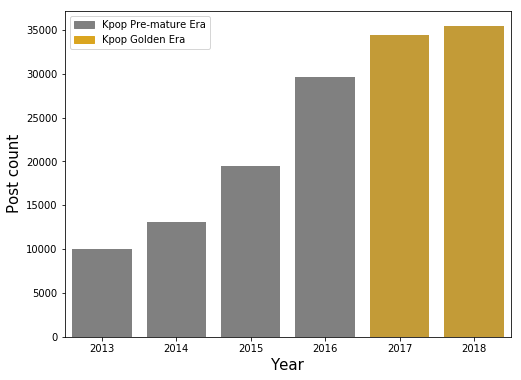

In [12]:
plt.figure(figsize=(8,6))
sns.countplot(x='Year', data=text, palette = ['grey','grey','grey', 'grey','goldenrod','goldenrod']);
plt.xlabel('Year', fontsize=15);
plt.ylabel('Post count', fontsize=15);
gold_patch = mpatches.Patch(color='goldenrod', label='Kpop Golden Era')
grey_patch = mpatches.Patch(color='grey', label='Kpop Pre-mature Era')
plt.legend(handles=[grey_patch,gold_patch])

The number of posts on Kpop subreddit is continuously growing every year since 2013. As mentioned above, the classifier we aim to build in this project is to identify which Reddit post is belonged to the year 2017 and 2018. We name these two years as "Kpop Golden Era" since the Kpop artists finally broke into American market and gained a lot of popularity in the mainstream media after many attempts.Therefore, we define the posts created in 2017 or 2018 as "class 1", and rest of posts as "class 0".

In [13]:
text['class'] = [1 if i in [2017,2018] else 0 for i in text_year]

In [14]:
text.head()

,Year,text,subchannel,class
0,2013,SNSD's 4th album (Youtube),['Playlist'],0
1,2013,Which was the Best 2013 Song Festival? Hi Guy...,['question/opinion'],0
2,2013,Sistar - New Year's Greetings (love the Eng su...,[],0
3,2013,Can anyone identify the song used on this cli...,['Song ID'],0
4,2013,After School - Flashback [Epitone Remix] [MV],['HD'],0


In [15]:
text.tail()

,Year,text,subchannel,class
141882,2018,"This Week In KPOP - December 15, 2018 Welcome ...",[],1
141883,2018,OH MY GIRL to appear on live tvN Variety Show ...,[],1
141884,2018,What k-pop song has this dance? It’s like maki...,[]discussion,1
141885,2018,MONSTA X Shownu's shoulder pops out during gre...,[]news,1
141886,2018,Special Stage: Under19 PerfomanceTeam - We Are...,[],1


The final resulted DataFrame includes:
> - `Year`: post creation year <br>
> - `text`: combined post title and body text <br>
> - `subchannel`: subchannel names.
> - `class`: 1-posts created in 2017 or 2018; 0-posts created before 2017

# 6. Save the DataFrame for further use

In [16]:
text.to_csv('../dataset/text.csv',index=None)

In [17]:
!head ../dataset/text.csv

Year,text,subchannel,class
2013, SNSD's 4th album (Youtube) ,['Playlist'] ,0
2013," Which was the Best 2013 Song Festival? Hi Guys, I usually watch/stream the music festivals, but I was a bit too busy this year. In your opinion, which one was the best?

The point is the best one is the one where I would watchy/download the 1080 version (and eat up my bandwidth) while the others would just be relegated to youtube streams :D

",['question/opinion'] ,0
2013,Sistar - New Year's Greetings (love the Eng subs!) ,[] ,0
2013, Can anyone identify the song used on this clip? Starts at 10minute ends at 12min. (From God's Quiz S1) ,['Song ID'] ,0
2013, After School - Flashback [Epitone Remix] [MV] ,['HD'] ,0
